# Introduction

Analysis of experimental data.

## Standard imports

In [3]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import time
np.random.seed(int(time.time()))

## Specific imports

In [4]:
from scipy.optimize import curve_fit
from noise_analysis import noise_color
from noise_properties_plotting import noise_cmap_ww, noise_lim
from scipy.stats import kstest, lognorm
from matplotlib import colorbar

#from neutral_covariance_test import *

## Settings figures

In [5]:
from elife_settings import set_elife_settings, ELIFE

set_elife_settings()

## Load experimental data

We use the plankton data of Martin Platero, the stool data of David and the timeseries of Caporaso.

In [6]:
# Load all dataframes

# MartinPlatero plankton data

df_ts = {}

path = 'Data/MartinPlatero/'
files = ['41467_2017_2571_MOESM4_ESM_MartinPlatero_Plankton_Bacteria.csv',
         '41467_2017_2571_MOESM5_ESM_MartinPlatero_Plankton_Eukarya.csv']
keys = ['plankton_bacteria', 'plankton_eukarya']

for i, f in enumerate(files):
    x = pd.read_csv(path+f, na_values='NAN', index_col=0)
    x = x.iloc[:, :-1] # delete last columns which contains details on the otu's
    
    # only keep 200 most abundant species
    sum_x = x.sum(axis='columns')
    
    x = x[sum_x >= np.sort(sum_x)[-200]]
    
    x = x.T # species are in rows instead of columns
    
    x.insert(0, 'time', [int(j[4:7]) for j in x.index]) # day
    
    x = x.groupby('time').agg('mean').reset_index()
    
    x.columns = ['time'] + ['species_%d' % j for j in range(1, len(x.columns))]
    
    df_ts[keys[i]] = x


# David stool data

files = ['Data/Faust/25_timeseries/25_timeseries.txt',
         'Data/Faust/28_timeseries/28_timeseries.txt']
keys = ['David_stool_A', 'David_stool_B']

for i, f in enumerate(files):
    x = pd.read_csv(f, na_values='NAN', delimiter='\t', header=None)
    
    x = x.T
    
    x.insert(0, 'time', range(len(x)))
    
    x.columns = ['time'] + ['species_%d' % j for j in range(1, len(x.columns))]
    
    df_ts[keys[i]] = x
    
# Caporaso body sites data

areas = ['feces', 'L_palm', 'R_palm', 'tongue']
gender = ['F4', 'M3']

for area in areas:
    for gender_i in gender:
        for taxlevel in range(2,7):
            file = 'Data/Caporaso/' + gender_i + '_' + area + '_L%d' % taxlevel + '.txt'
            key = 'Caporaso_' + gender_i + '_' + area + '_L%d' % taxlevel 
            
            x = pd.read_csv(file, delimiter='\t', skiprows=1, index_col=0, header=None)
            #x = x[x.sum(axis='rows') > 0]
                        
            x.index = ['time'] + ['species_%d' % j for j in range(1, len(x.index))]
            
            x = x.T
            
            # only keep 200 most abundant species
            if len(x.columns) > 201:
                sum_x = x.sum(axis='rows')
                
                sum_x['time'] = np.inf
                
                sum_x.sort_values(ascending=False, inplace=True)
                
                x = x[sum_x.index.tolist()[:201]]
            
            x.columns = ['time'] + ['species_%d' % j for j in range(1, len(x.columns))]
    
            df_ts[key] = x

## Code to generate figures

In [7]:
def small_setup(composition=None):
    fig = plt.figure(figsize=(6.5,6)) #, tight_layout=True)
    nrows = 2
    ncols = 2
    
    if composition == 'disdx':
        gs = gridspec.GridSpec(nrows,ncols,wspace=0.1,hspace=0.1, right=0.8)
        gs_cbar = gridspec.GridSpec(1, 1, left=0.87)
        gs_tot = gridspec.GridSpec(1,1,top=0.9,bottom=0.08,left=0.07,right=0.8)
    else:
        gs = gridspec.GridSpec(nrows,ncols,wspace=0.1,hspace=0.1)
        gs_cbar = None
        gs_tot = gridspec.GridSpec(1,1,top=0.9,bottom=0.08,left=0.05,right=0.9)

    keys = ['plankton_bacteria', 'David_stool_A', 
            'Caporaso_F4_L_palm_L6', 'Caporaso_F4_tongue_L6']

    titles = ['Plankton bacteria', 'David Stool A', 
              'Caporaso palm', 'Caporaso tongue']
    
    return fig, nrows, ncols, gs, gs_cbar, gs_tot, keys, titles

def large_setup(composition=None):
    fig = plt.figure(figsize=(ELIFE.TEXTWIDTH,2.5)) #, tight_layout=True)
    
    nrows = 3
    ncols = 4
    
    if composition == 'disdx':
        gs = gridspec.GridSpec(nrows,ncols,wspace=0.1,hspace=0.12,top=0.98,bottom=0.12,left=0.08,right=0.85)
        gs_cbar = gridspec.GridSpec(1, 1, top=0.98,bottom=0.1,left=0.88, right=0.9)
    else:
        gs = gridspec.GridSpec(nrows,ncols,wspace=0.1,hspace=0.1,top=0.98,bottom=0.15,left=0.12,right=0.98)
        gs_cbar = None
        gs_tot = gridspec.GridSpec(1,1,top=0.98,bottom=0.06,left=0.05,right=0.98)
    
    if composition == 'disdx':
        gs_tot = gridspec.GridSpec(1,1,top=0.98,bottom=0.06,left=0.03,right=0.85)
    elif composition == 'nc':
        gs_tot = gridspec.GridSpec(1,1,top=0.98,bottom=0.07,left=0.07,right=0.98)
    elif composition == 'dx':
        gs_tot = gridspec.GridSpec(1,1,top=0.98,bottom=0.08,left=0.07,right=0.98)
        
    keys = ['David_stool_A', 'David_stool_B',
            'plankton_bacteria', 'plankton_eukarya',
            'Caporaso_F4_feces_L6', 'Caporaso_M3_feces_L6',
            'Caporaso_F4_L_palm_L6', 'Caporaso_M3_L_palm_L6',
            'Caporaso_F4_R_palm_L6', 'Caporaso_M3_R_palm_L6',
            'Caporaso_F4_tongue_L6', 'Caporaso_M3_tongue_L6']

    titles = ['Stool A', 'Stool B', 
              'Plankton bacteria', 'Plankton eukarya',
              'Female feces', 'Male feces',
                'Female left palm', 'Male left palm',
                'Female right palm', 'Male right palm',
                'Female tongue', 'Male tongue']
    
    return fig, nrows, ncols, gs, gs_cbar, gs_tot, keys, titles

In [19]:
def compare_experimental_data(setup, composition=[], labels = 'in'):
    fig, nrows, ncols, gs, gs_cbar, gs_tot, keys, titles = setup
    
    for i, gsi, key, title in zip(np.arange(len(keys)), gs, keys, titles):
        # make axes and write lable
        if i == 0:
            ax = fig.add_subplot(gsi)
        else:
            ax = fig.add_subplot(gsi, sharex=ax, sharey=ax)
        if labels == 'in':
            ax.text(0.95 if composition == 'ra' else 0.05, 0.95, 
                    title, transform=ax.transAxes,
                  va='top', ha='right' if composition ==  'ra' else 'left' )
        elif labels == 'out':
            ax.set_title(title)

        df = df_ts[key]

        mean = df.mean()
        mean.drop('time', inplace=True)
        
        if composition == 'disdx' or composition == 'disdx2':
            
            def fit_ratio(x):
                # ratios of succesive time points without infinity and 0
                x = [x1/x2 for x1, x2 in zip(x[:-1], x[1:]) if x1 != 0 and x2 != 0 ] 
                
                if len(x) > 5:
                    a, b, c = lognorm.fit(x, floc=0)  # Gives the paramters of the fit
                    stat, pval = kstest(x, 'lognorm', args=((a, b, c))) # get pvalue for kolmogorov-smirnov test 
                    # (null hypothesis: ratios of succesive time points follow lognorm distribution)

                    return a, b, c, stat, pval
                else:
                    return (np.nan, np.nan, np.nan, np.nan, np.nan)


            dx_ratio = pd.DataFrame(index=df.columns, columns=['s', 'loc', 'scale', 'kstest-statistic', 'kstest-pvalue'])
            dx_ratio.drop('time', axis='rows', inplace=True)

            for idx in dx_ratio.index:
                a, b, c, stat, pval = fit_ratio(df[idx].values)  # b = 0, c = 1
                dx_ratio['s'].loc[idx] = a
                dx_ratio['loc'].loc[idx] = b
                dx_ratio['scale'].loc[idx] = c
                dx_ratio['kstest-statistic'].loc[idx] = stat
                dx_ratio['kstest-pvalue'].loc[idx] = pval
            
            if composition == 'disdx':
                scat = ax.scatter(mean, dx_ratio['s'].values, 
                       c=dx_ratio['kstest-pvalue'].values, vmin=0, vmax=1, cmap='coolwarm', s=3) #, label=param)
            elif composition == 'disdx2':
                def find_ss_selfint(x):
                    amplitude = 2.10E+00 
                    x0 = 2.87E+00
                    k = 1.14E+00
                    offset = -1.77E+00
                    
                    ss_selfint = np.full_like(x, np.nan)
                    y = np.zeros_like(x)
                    
                    y[~np.isnan(x)] = amplitude/(x[~np.isnan(x)]-offset) - 1
                    
                    ss_selfint[y>0] = 10**( -1/x0 * np.log(y[y>0]) + k)
                    return ss_selfint 

                ns = noise_color(df_ts[key])['slope_linear']
                
                selfints = find_ss_selfint(ns.values) / mean.values #.flatten()

                scat = ax.scatter(mean * selfints, dx_ratio['s'].values, 
                       c=dx_ratio['kstest-pvalue'].values, vmin=0, vmax=1, cmap='coolwarm', s=3) #, label=param)
        
        
            #ax.set_xlim([0.1*np.nanmin(mean.values), 10*np.nanmax(mean.values)])
            #ax.set_ylim([0.5*np.nanmin(dx_ratio['s'].values), 5*np.nanmax(dx_ratio['s'].values)])

            ax.set_yscale('log')
            ax.set_xscale('log')
        
        if composition == 'nc':
            vmin = 0.1*mean.min()
            vmax = 10*mean.max()

            ns = noise_color(df_ts[key])['slope_linear']
            ax.scatter(mean, ns, s=3)

            xx = np.linspace(2, -3, 500).reshape([500, 1])
            ax.imshow(xx, cmap=noise_cmap_ww, vmin = noise_lim[0], vmax= noise_lim[1], extent=(1e-3, 2e5, -3, 2),
                         aspect='auto', alpha=0.75)

            ax.set_xscale('log')
        
        if composition == 'dx':
            dx = pd.DataFrame(index=df.columns, columns=['abs_dx'])
            dx.drop('time', axis='rows', inplace=True)

            for idx in dx.index:
                dx['abs_dx'].loc[idx] = np.nanmean(abs(df[idx].values[1:] - df[idx].values[:-1]))

            ax.scatter(mean, dx['abs_dx'].values, s=3)

            p_lin = np.polyfit(np.log10(mean.astype(np.float64)), np.log10(dx.astype(np.float64)), deg=1, cov=False)

            xx = [np.nanmin(mean.values), np.nanmax(mean.values)]
            ax.plot(xx, 10**(p_lin[1] + p_lin[0]*np.log10(xx)), c = 'k', linewidth=0.5)            
            
            ax.text(0.95, 0.05, r'y $\propto$ x$^{%.2f}$' % p_lin[0], transform=ax.transAxes,
              va='bottom', ha='right')
        
            ax.set_yscale('log')
            ax.set_xscale('log')
        
        if composition == 'ra':
            timepoints = [1, 30, 60] if key != 'David_stool_A' else [1, 50, 100, 108, 300]

            for j in timepoints:
                d = np.copy(df_ts[key].iloc[j])
                d /= np.sum(d)
                ax.plot(range(1,len(d)+1), np.sort(d)[::-1], label='Day %d' % j)

                ax.set_ylim([1e-8,1])
                ax.legend(loc=3)
                ax.set_xscale('log')
                ax.set_yscale('log')                
        
        ax.grid()

        if i%ncols != 0:
            ax.tick_params(axis="both", left=True, labelleft=False)
        if i < (nrows-1)*ncols:
            ax.tick_params(axis="both", bottom=True, labelbottom=False)

    if composition == 'disdx' or composition == 'disdx2':
        ax_cbar = fig.add_subplot(gs_cbar[0])
        fig.colorbar(scat, cax=ax_cbar)
        ax_cbar.set_ylabel('P-value lognormal fit')
    
    # add labels (common for all subplots)
    ax = fig.add_subplot(gs_tot[0], frameon=False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    if composition == 'ra':
        ax.set_xlabel('Rank', ha='right', x=1)
    elif composition == 'disdx2':
        ax.set_xlabel(r'Mean abundance $\times$ associated self-interaction', ha='right', x=1) 
    else:
        ax.set_xlabel('Mean abundance', ha='right', x=1) 
    
    if composition == 'nc':
        ax.set_ylabel('Slope power spectral density')
    elif composition == 'disdx' or composition == 'disdx2':
        ax.set_ylabel('Width distribution of ' + r'$x(t+\delta t) / x(t)$')
    elif composition == 'dx':
        ax.set_ylabel(r'$\langle \vert x(t + \delta t) - x(t) \vert \rangle$')
    elif composition == 'ra':
        ax.set_ylabel('Abundance') 

# Analysis

## Rank abundance curve

The rank abundance is heavy tailed. This means that there are few abundant species and many rare species.

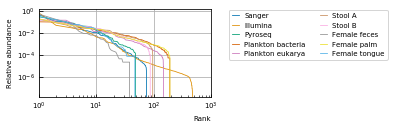

In [13]:
# system dependence

fig = plt.figure(figsize=(ELIFE.TEXTWIDTH,1.8), tight_layout=True)
gs = gridspec.GridSpec(1,2,width_ratios=[1.5,1])

ax = fig.add_subplot(gs[0])

NUM_COLORS = 10

# Static data

path = 'Data/Arumugam/'
files = ['MetaHIT_41SangerSamples.genus.csv', #'MetaHIT_41SangerSamples.phylum.csv',
          'MetaHIT_85IlluminaSamples.genus.csv', 'Turnbaugh_154Pyroseq16S.genus.csv']
titles = ['Sanger', #'Sanger phylum', 
          'Illumina', 'Pyroseq']

for file, title in zip(files, titles):
    i = 0
    if title == 'Sanger':
        i = 4
        
    d = pd.read_csv(path + file, index_col=0).values[1:,i]
    d /= np.sum(d)
    ax.plot(range(1,len(d)+1), np.sort(d)[::-1], label=title)
 
keys = ['plankton_bacteria', 'plankton_eukarya', 'David_stool_A', 'David_stool_B', 
        'Caporaso_F4_feces_L6', 'Caporaso_F4_L_palm_L6', 'Caporaso_F4_tongue_L6']

titles = ['Plankton bacteria', 'Plankton eukarya', 'Stool A', 'Stool B', 
          'Female feces', 'Female palm', 'Female tongue']

for key, title in zip(keys, titles):
    d = np.copy(df_ts[key].values[0,1:])
    d /= np.sum(d)
    ax.plot(range(1,len(d)+1), np.sort(d)[::-1], label=title)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim([1,1000])
ax.grid()
ax.set_xlabel('Rank', ha='right', x=1)
ax.set_ylabel('Relative abundance')

ax_legend = fig.add_subplot(gs[1])
ax_legend.axis('off')
handles, labels = ax.get_legend_handles_labels()
ax_legend.legend(handles, labels, handlelength=1, ncol=2)

plt.show()

The curve can not be exactly matched with a lognorm or powerlaw.
TODO: check fit of these curves for histograms of abundances!

In [18]:
from scipy.interpolate import interp1d
from fractions import gcd


def keys_titles_experimental():
    keys = ['plankton_bacteria', 'plankton_eukarya',
            'David_stool_A', 'David_stool_B']

    titles = ['Plankton bacteria', 'Plankton eukarya',
              'David Stool A', 'David Stool B']

    areas = ['feces', 'L_palm', 'R_palm', 'tongue']
    gender = ['F4', 'M3']

    for area in areas:
        for gender_i in gender:
            for taxlevel in range(2, 7):
                keys += ['Caporaso_' + gender_i +
                         '_' + area + '_L%d' % taxlevel]
                titles += [gender_i + ' ' + area + ' L%d' % taxlevel]
    return keys, titles


def calculate_neutrality(keys):
    neutrality = pd.DataFrame(index=keys, columns=['KL', 'NCT'])

    for key in keys:
        if True:  # np.isnan(neutrality['NCT'].loc[key]):
            if np.isnan(neutrality['KL'].loc[key]):
                print(df_ts[key].columns)
                if key.startswith('Caporaso'):
                    neutrality['KL'].loc[key] = KullbackLeibler(
                        df_ts[key].drop(df_ts[key].columns[-1], axis='columns'))
                else:
                    neutrality['KL'].loc[key] = KullbackLeibler(
                        df_ts[key])  # , verbose=True)
                norm_ts = df_ts[key].values[:, 1:]
                norm_ts /= norm_ts.sum(axis=1, keepdims=True)
                neutrality['NCT'].loc[key] = neutral_covariance_test(
                    norm_ts, ntests=500, method='Kolmogorov', seed=56)

    neutrality.to_csv('experimental_neutrality.csv')


def calculate_timestep_slope(keys):
    timestep = pd.DataFrame(index=keys, columns=['slope'])

    for key in keys:
        x = df_ts[key]
        x = x.loc[:, (x != 0).any(axis=0)]

        mean = x.mean()
        mean.drop('time', inplace=True)

        dx = (x.values[1:, 1:] - x.values[:-1, 1:])  # / x.values[:-1, 1:];
        dx[~np.isfinite(dx)] = np.nan
        mean_dx = np.nanmean(abs(dx), axis=0)

        p_lin = np.polyfit(np.log10(mean), np.log10(mean_dx), deg=1, cov=False)

        timestep['slope'].loc[key] = p_lin[0]

    timestep.to_csv('experimental_timestep_slope.csv')


def lognormal(x, mu, sigma, scale):
    return scale/(x*sigma*np.sqrt(2*np.pi))*np.exp(-0.5*((np.log(x)-mu)/sigma)**2)


def powerlaw(x, index, amp):
    return amp * x ** index


def logseries(x, p):
    r = np.full_like(x, np.nan)
    if p == 0:
        return r
    r[x > 0] = -1/(np.log(1-p)) * p**x[x > 0]/x[x > 0]
    return r


def rank_abundance_fit_parameters(keys):
    ra = pd.DataFrame(index=keys, columns=['rss_lognormal', 'mu_lognormal', 'sigma_lognormal', 'scale_lognormal',
                                           'rss_powerlaw', 'index_powerlaw', 'amp_powerlaw',
                                           'index_powerlaw_linfit', 'amp_powerlaw_linfit',
                                           'rss_logseries', 'p_logseries'])

    for key in keys:
        y = df_ts[key].values[0, 1:]
        y = y[y > 0]
        y = np.sort(y)[::-1]

        x = np.arange(1, len(y)+1)

        popt, pcov = curve_fit(lognormal, x, y, p0=[0.01, 1, 10])
        mu, sigma, scale = popt

        ra['rss_lognormal'].loc[key] = sum(
            (lognormal(x, mu, sigma, scale) - y)**2)
        ra['mu_lognormal'].loc[key] = mu
        ra['sigma_lognormal'].loc[key] = sigma
        ra['scale_lognormal'].loc[key] = scale

        p_lin = np.polyfit(np.log10(x), np.log10(y), deg=1, cov=False)

        index0 = p_lin[0]
        amp0 = 10.0**p_lin[1]

        popt, pcov = curve_fit(powerlaw, x, y, p0=[index0, amp0])
        index, amp = popt

        #indexErr = np.sqrt( covar[1][1] )
        #ampErr = np.sqrt( covar[0][0] ) * amp

        ra['index_powerlaw'].loc[key] = index
        ra['amp_powerlaw'].loc[key] = amp
        ra['rss_powerlaw'].loc[key] = sum((powerlaw(x, index, amp) - y)**2)
        ra['index_powerlaw_linfit'].loc[key] = index0
        ra['amp_powerlaw_linfit'].loc[key] = amp0

        p, perr = curve_fit(logseries, x, y, p0=0.5)

        ra['rss_logseries'].loc[key] = sum((logseries(x, p) - y)**2)
        ra['p_logseries'].loc[key] = p

    return ra

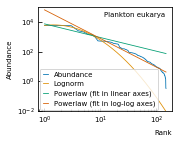

In [19]:
key = 'plankton_eukarya' #'David_stool_A'
title = 'Plankton eukarya'

params = rank_abundance_fit_parameters([key])

abundance = np.copy(df_ts[key].values[0, 1:])
abundance = abundance[abundance > 0]
abundance = np.sort(abundance)[::-1]

rank = np.arange(1,len(abundance)+1)

fig = plt.figure(figsize=(2.5,2), tight_layout=True)
ax = fig.add_subplot(111)
ax.text(0.95, 0.95, title, transform=ax.transAxes,
              va='top', ha='right')

ax.plot(rank, abundance, label='Abundance')

x = np.logspace(0,np.log10(len(abundance)),500)

ax.plot(x, lognormal(x, params['mu_lognormal'].loc[key], 
                     params['sigma_lognormal'].loc[key], 
                     params['scale_lognormal'].loc[key]), label='Lognorm')

ax.plot(x, params['amp_powerlaw'].loc[key]*(x**params['index_powerlaw'].loc[key]), 
        label='Powerlaw (fit in linear axes)')

ax.plot(x, params['amp_powerlaw_linfit'].loc[key]*(x**params['index_powerlaw_linfit'].loc[key]), 
        label='Powerlaw (fit in log-log axes)')

#plt.plot(x, logseries(x, 0.3), label='logseries')

ax.legend(loc=3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-2,1e5])

ax.set_xlabel('Rank', ha='right', x=1)
ax.set_ylabel('Abundance')

plt.show()

The rank abundance curve is mostly stable over time.

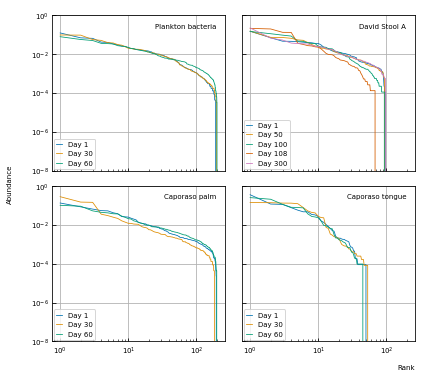

In [20]:
compare_experimental_data(small_setup('ra'), composition='ra', labels = 'in')
plt.show()

## Analysis of the noise

The noise color is independent of the mean abundance. The noise colors are often in the pink to white region.

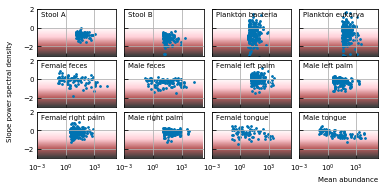

In [28]:
compare_experimental_data(large_setup('nc'), composition='nc', labels = 'in')
plt.show()

We fit the ratios of abundances between successive time points with lognormal curves. The fits are mostly good (high p-values). The widths of the distributions are large (order 1) and independent of the mean abundance.

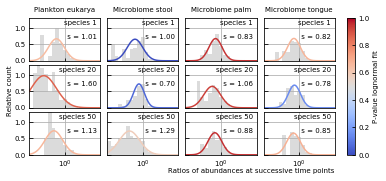

In [37]:
fig = plt.figure(figsize=(ELIFE.TEXTWIDTH,2.5)) #, tight_layout=True)

nrow = 3
ncol = 4

gs = gridspec.GridSpec(nrow,ncol,wspace=0.1,hspace=0.1, left=0.08, bottom=0.12, right=0.85)
gs_tot = gridspec.GridSpec(1,1, bottom=0.07, left=0.05, right=0.85)
gs_cbar = gridspec.GridSpec(1, 1, left=0.88, bottom= 0.12, right=0.9)

gs = np.array([[gs[i,j] for j in range(ncol)] for i in range(nrow)])

keys = ['plankton_eukarya', 'David_stool_A',
        'Caporaso_F4_L_palm_L6', 'Caporaso_F4_tongue_L6']

titles = ['Plankton eukarya', 'Microbiome stool', 
          'Microbiome palm', 'Microbiome tongue']

def ratio(x):
    x = x[:-1]/x[1:]
    x = x[np.isfinite(x)]
    return x

def fit_ratio(x):
    # ratios of succesive time points
    x = [x1/x2 for x1, x2 in zip(x[:-1], x[1:]) if x1 != 0 and x2 != 0]
    
    if len(x) > 5:
        a, b, c = lognorm.fit(x, floc=0)  # Gives the paramters of the fit
        stat, pval = kstest(x, 'lognorm', args=((a, b, c))) # get pvalue for kolmogorov-smirnov test 
        # (null hypothesis: ratios of succesive time points follow lognorm distribution)
    
        #a, b = stats.norm.fit(x) #, floc=0)  # Gives the paramters of the fit
        #c = 0
        #stat, pval = kstest(x, 'norm', args=((a, b))) # get pvalue for kolmogorov-smirnov test 
        
        return a, b, c, stat, pval
    else:
        return (np.nan, np.nan, np.nan, np.nan, np.nan)

cmap = plt.cm.get_cmap('coolwarm')


for i, key, title in zip(np.arange(len(keys)), keys, titles):
    df = df_ts[key]

    # plot different mean abundances, first sort the species
    sorted_idces = df.mean().sort_values().index.tolist()[::-1]
    sorted_idces.remove('time')

    mean = df.mean()
    
    for j, gsi, num in zip(np.arange(nrow), gs[:,i], [1, 20, 50]):
        if i == 0 and j == 0:
            ax = fig.add_subplot(gsi)
        else:
            ax = fig.add_subplot(gsi, sharey=ax)
        
        if j == 0:
            ax.set_title(title)

        idx = sorted_idces[num]
        
        x = df[idx].values
        
        x_transf = [x1/x2 for x1, x2 in zip(x[:-1], x[1:]) if x1 != 0 and x2 != 0]
        
        a, b, c, stat, pval = fit_ratio(x)

        bound = 1.95

        x_fit = np.logspace(-bound,bound,100)
        pdf_fitted = lognorm.pdf(x_fit,a,b,c) #Gives the PDF
        #pdf_fitted = stats.norm.pdf(x_fit,a,b) #Gives the PDF

        ax.hist(x_transf, density=True, color='lightgrey', alpha=0.8,
                bins = np.logspace(-bound,bound,20))
        ax.plot(x_fit, pdf_fitted, color=cmap(pval), linewidth=1.5)
        ax.grid()

        ax.set_xscale('log')
        ax.set_xlim([10**(-bound),10**bound])

        if i > 0:
            ax.tick_params(axis="both", left=True, labelleft=False)
        if j < nrow - 1:
            ax.tick_params(axis="both", bottom=True, labelbottom=False)

        label = 'species %d' % num + '\n \n s = %.2f' % a

        ax.text(0.95, 0.95, label, transform=ax.transAxes,
              va='top', ha='right')
            
            
ax.set_ylim([0, 1.3])

ax_tot = fig.add_subplot(gs_tot[0], frameon=False)
ax_tot.set_ylabel('Relative count')
ax_tot.set_xlabel('Ratios of abundances at successive time points', ha='right', x=1)
ax_tot.set_xticks([])
ax_tot.set_yticks([])

ax_cbar = fig.add_subplot(gs_cbar[0])
colorbar.ColorbarBase(ax_cbar, cmap=plt.cm.coolwarm,
                            orientation='vertical')

ax_cbar.set_ylabel('P-value lognormal fit')

plt.show()

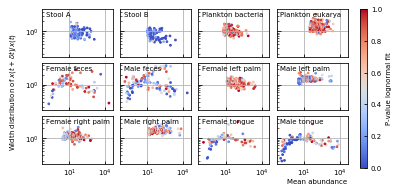

In [40]:
compare_experimental_data(large_setup('disdx'), composition='disdx', labels = 'in')
plt.show()

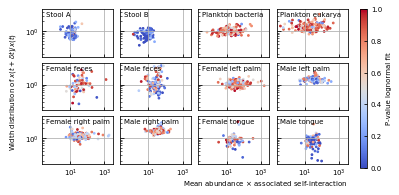

In [20]:
compare_experimental_data(large_setup('disdx'), composition='disdx2', labels = 'in')
plt.show()

The mean absolute difference between successive time steps describe a monomial (linear in log-logscale) with the mean abundance. This hints at a linear source of the noise.

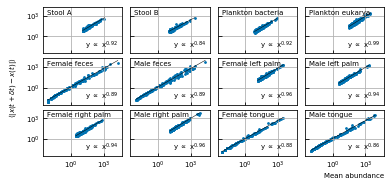

In [43]:
compare_experimental_data(large_setup('dx'), composition='dx', labels = 'in')
plt.show()

## Neutrality

Most of the experimental data is neutral for both neutrality measures.

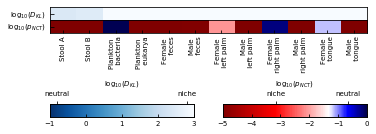

In [80]:
neutrality = pd.read_csv('results/experimental/neutrality.csv', index_col=0)

keys = ['David_stool_A', 'David_stool_B',
        'plankton_bacteria', 'plankton_eukarya',
        'Caporaso_F4_feces_L6', 'Caporaso_M3_feces_L6',
        'Caporaso_F4_L_palm_L6', 'Caporaso_M3_L_palm_L6',
        'Caporaso_F4_R_palm_L6', 'Caporaso_M3_R_palm_L6',
        'Caporaso_F4_tongue_L6', 'Caporaso_M3_tongue_L6']

titles = ['Stool A', 'Stool B', 
          'Plankton \n bacteria', 'Plankton \n eukarya',
          'Female \n feces', 'Male \n feces',
            'Female \n left palm', 'Male \n left palm',
            'Female \n right palm', 'Male \n right palm',
            'Female \n tongue', 'Male \n tongue']

neutrality = neutrality.loc[keys]

fig = plt.figure(figsize=(ELIFE.TEXTWIDTH,1.8)) #, tight_layout=True)

gs1 = gridspec.GridSpec(2,1,hspace=0, left = 0.15, bottom=0.75, top=0.95, right=0.95)
gs2 = gridspec.GridSpec(1,2,wspace=0.2, left = 0.15, top=0.2, bottom=0.1, right=0.95)

ax_KL = fig.add_subplot(gs1[0])
ax_clb_KL = fig.add_subplot(gs2[0])
ax_NCT = fig.add_subplot(gs1[1])
ax_clb_NCT = fig.add_subplot(gs2[1])
ax_KL.set_facecolor('lightgrey')
ax_NCT.set_facecolor('lightgrey')

# KL

KL = np.log10(neutrality['KL'].values.astype(np.float64))
KL = KL.reshape([1, len(KL)])
KL[np.isinf(KL)] = 3.0
mat_KL = ax_KL.matshow(KL, origin='lower', cmap='Blues_r', aspect='auto', vmin=-1, vmax=3)

ax_KL.set_yticks([0])
ax_KL.set_yticklabels([r'log$_{10}$($D_{KL}$)'])

ax_KL.tick_params(axis="both", bottom=False, top=False, labelbottom=False, labeltop=False, left=True, labelleft=True)

fig.colorbar(mat_KL, cax=ax_clb_KL, orientation='horizontal')
ax_clb_KL.set_title(r'log$_{10}$($D_{KL}$)')


# NCT 

NCT = np.log10(neutrality['NCT'].values.astype(np.float64))
NCT = NCT.reshape([1, len(NCT)])

vmin = -5; vmax = 0 # pvalue is max 1 = 1e0
norm = PiecewiseNormalize([vmin, np.log10(0.05), vmax], [0, 0.5, 1])
mat_NCT = ax_NCT.matshow(NCT, origin='lower', norm=norm, 
                     cmap='seismic_r', aspect='auto', vmin=vmin, vmax=vmax)
fig.colorbar(mat_NCT, cax=ax_clb_NCT, orientation='horizontal')

ax_NCT.set_xticks(range(len(NCT[0])))
ax_NCT.set_xticklabels(titles)

ax_NCT.set_yticks([0])
ax_NCT.set_yticklabels([r'log$_{10}$($p_{NCT}$)'],)

# Set ticks on both sides of axes on
ax_NCT.tick_params(axis="both", bottom=True, top=False, 
                   labelbottom=True, labeltop=False, left=True, labelleft=True)
ax_clb_NCT.set_title(r'log$_{10}$($p_{NCT}$)')

# Rotate and align bottom ticklabels
plt.setp([tick.label1 for tick in ax_NCT.xaxis.get_major_ticks()], rotation=90,
         ha="right", va="center", rotation_mode="anchor")
plt.setp([tick.label1 for tick in ax_NCT.yaxis.get_major_ticks()], rotation=0,
        ha="right", va="center")

ax_clb2 = ax_clb_KL.twiny()
ax_clb_KL.xaxis.set_ticks_position('bottom')
ax_clb2.xaxis.set_ticks_position('top')
ax_clb2.xaxis.set_ticks([0.05,0.95])
ax_clb2.set_xlim([0,1])
ax_clb2.xaxis.set_ticklabels(['neutral','niche'])
ax_clb2.tick_params(axis='x', direction='out')

ax_clb2 = ax_clb_NCT.twiny()
ax_clb_NCT.xaxis.set_ticks_position('bottom')
ax_clb2.xaxis.set_ticks_position('top')
ax_clb2.xaxis.set_ticks([1+(vmin + np.log10(0.05))/(vmax - vmin)/2,
                        1+(vmax + np.log10(0.05))/(vmax - vmin)/2])
ax_clb2.set_xlim([0,1])
ax_clb2.xaxis.set_ticklabels(['niche','neutral'])
ax_clb2.tick_params(axis='x', direction='out')

plt.show()